In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, confusion_matrix, accuracy_score
from collections import Counter
from helpers import resample_data
from sklearn.decomposition import TruncatedSVD
from helpers import resample_data, svd_reduce_and_combine, get_submission_ready

In [3]:
X_train_full = pd.read_csv("data/components/X_train.csv")
y_train_full = pd.read_csv("data/components/y_train.csv")

In [24]:
# X_train = pd.read_csv("data/components/half_X_train.csv")
# y_train = pd.read_csv("data/components/half_y_train.csv")
# X_test = pd.read_csv("data/components/X_test.csv")
y_test = pd.read_csv("data/components/y_test.csv")
# submission = pd.read_csv("data/components/submission.csv")

In [4]:
X_train_qt = pd.read_csv("data/components/quarter_X_train.csv")
y_train_qt = pd.read_csv("data/components/quarter_y_train.csv")

In [4]:
X_train_tfidf = pd.read_csv("data/components/tfidf/X_train_full.csv")
X_test_tfidf  = pd.read_csv("data/components/tfidf/X_test_full.csv")
submission_tfidf = pd.read_csv("data/components/tfidf/submission_full.csv")

In [25]:
X_train_tfidf_downsized, y_train_tfidf = resample_data(0.1, X_train_tfidf, y_train_full)

new training size is (118823, 508)


In [32]:
def svd_reduce_and_combine(X_train, end=500, components=250):
    """ 
        end is number of columns that is tf-idf (500 by default)
        components is the svd deconstruction lim (250 by default)
    """
    X_train_tfidf = X_train.iloc[:, :end]
    X_train_non_tfidf = X_train.iloc[:, end:]

    svd = TruncatedSVD(n_components=components, random_state=123)
    X_train_tfidf_reduced = svd.fit_transform(X_train_tfidf)

    X_train_reduced = np.hstack((X_train_tfidf_reduced, X_train_non_tfidf.values))

    columns = [f'SVD_{i+1}' for i in range(components)] + list(X_train_non_tfidf.columns)
    X_train_reduced = pd.DataFrame(X_train_reduced, columns=columns)

    return X_train_reduced


In [7]:
X_train_tfidf_svd = svd_reduce_and_combine(X_train_tfidf, 1251, 500)
X_train_tfidf_svd.head(2)

,SVD_1,SVD_2,SVD_3,SVD_4,SVD_5,SVD_6,SVD_7,SVD_8,SVD_9,SVD_10,...,SVD_497,SVD_498,SVD_499,SVD_500,Helpful,Unhelpful,SummarySentiment,CleanedTextSentiment,ProductAvgScore,UserAvgScore
0,0.211409,-0.112633,-0.090526,-0.051251,0.156629,0.011992,0.011334,-0.029710,-0.043538,0.035935,...,-0.010525,0.024100,0.032481,0.004525,0.0,0.0,-0.5719,-0.8781,3.2,3.781513
1,0.223712,0.183340,-0.017372,0.003127,-0.102013,0.094960,0.123757,0.081925,-0.056831,0.034002,...,0.001626,0.018973,0.034540,-0.028148,0.0,0.0,-0.8151,-0.8834,2.5,2.916667


In [8]:
X_test_tfidf_svd = svd_reduce_and_combine(X_test_tfidf, 1251, 500)
X_test_tfidf_svd.head(2)

,SVD_1,SVD_2,SVD_3,SVD_4,SVD_5,SVD_6,SVD_7,SVD_8,SVD_9,SVD_10,...,SVD_497,SVD_498,SVD_499,SVD_500,Helpful,Unhelpful,SummarySentiment,CleanedTextSentiment,ProductAvgScore,UserAvgScore
0,0.076390,-0.013696,0.023456,-0.003444,0.001449,0.024261,-0.039077,0.011237,-0.006785,-0.016443,...,0.010917,-0.009274,-0.013415,-0.006946,0.0,0.0,0.000,0.7269,3.448276,5.0
1,0.140234,-0.065710,0.163713,0.047195,0.098612,0.302426,-0.055715,0.016553,-0.063248,-0.002805,...,-0.006823,0.050506,-0.038708,-0.043676,0.0,5.0,-0.296,0.0000,4.909091,4.2


In [9]:
submission_tfidf_svd = svd_reduce_and_combine(submission_tfidf, 1251, 500)
submission_tfidf_svd.head(2)

,SVD_1,SVD_2,SVD_3,SVD_4,SVD_5,SVD_6,SVD_7,SVD_8,SVD_9,SVD_10,...,SVD_497,SVD_498,SVD_499,SVD_500,Helpful,Unhelpful,SummarySentiment,CleanedTextSentiment,ProductAvgScore,UserAvgScore
0,0.297960,0.023020,-0.002206,-0.021551,-0.106621,0.014434,0.015654,0.016487,0.009783,-0.078937,...,-0.026912,0.001740,-0.019234,0.024498,0.0,0.0,0.2263,0.9894,3.478548,2.545455
1,0.207349,0.155073,0.056517,0.016585,0.065189,-0.095659,-0.069187,0.093695,-0.055305,-0.072975,...,0.014345,0.033312,0.046654,-0.011647,1.0,0.0,0.6249,0.9360,4.182927,4.214286


In [22]:
# EVALUATION FUNCTION
def evaluate(y_pred):
    accuracy = accuracy_score(y_test, y_pred) * 100

    print(confusion_matrix(y_test, y_pred))
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"prediction set: {Counter(y_pred)}")

## Scaler

In [10]:
X_train_tfidf_svd['UserAndProduct'] = (X_train_tfidf_svd['ProductAvgScore'] + X_train_tfidf_svd['UserAvgScore']) / 2
X_train_tfidf_svd=X_train_tfidf_svd.drop(columns=['ProductAvgScore', 'UserAvgScore'], axis=1)

In [11]:
X_test_tfidf_svd['UserAndProduct'] = (X_test_tfidf_svd['ProductAvgScore'] + X_test_tfidf_svd['UserAvgScore']) / 2
X_test_tfidf_svd=X_test_tfidf_svd.drop(columns=['ProductAvgScore', 'UserAvgScore'], axis=1)
submission_tfidf_svd['UserAndProduct'] = (submission_tfidf_svd['ProductAvgScore'] + submission_tfidf_svd['UserAvgScore']) / 2
submission_tfidf_svd=submission_tfidf_svd.drop(columns=['ProductAvgScore', 'UserAvgScore'], axis=1)

In [13]:
X_train_tfidf_svd.head()

,SVD_1,SVD_2,SVD_3,SVD_4,SVD_5,SVD_6,SVD_7,SVD_8,SVD_9,SVD_10,...,SVD_496,SVD_497,SVD_498,SVD_499,SVD_500,Helpful,Unhelpful,SummarySentiment,CleanedTextSentiment,UserAndProduct
0,0.211409,-0.112633,-0.090526,-0.051251,0.156629,0.011992,0.011334,-0.029710,-0.043538,0.035935,...,0.025086,-0.010525,0.024100,0.032481,0.004525,0.0,0.0,-0.5719,-0.8781,3.490756
1,0.223712,0.183340,-0.017372,0.003127,-0.102013,0.094960,0.123757,0.081925,-0.056831,0.034002,...,-0.019391,0.001626,0.018973,0.034540,-0.028148,0.0,0.0,-0.8151,-0.8834,2.708333
2,0.233048,-0.042692,0.006486,-0.020101,-0.068753,-0.018537,-0.036192,-0.018070,0.053127,-0.038649,...,0.012679,-0.025018,0.016710,0.079102,0.021065,0.0,17.0,0.0000,0.6808,2.761364
3,0.194330,-0.075995,-0.039064,-0.041415,0.017049,-0.032864,0.047347,-0.013141,0.022534,0.040042,...,-0.015096,0.023007,0.011615,-0.019842,-0.012107,2.0,0.0,0.8271,0.9081,3.819444
4,0.164560,-0.048288,0.017197,-0.023012,0.004337,-0.032888,0.027271,0.036193,0.071371,0.003270,...,0.019929,0.026155,0.002882,0.002064,-0.006673,0.0,0.0,0.2732,-0.1027,3.178788


In [14]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler() 

columns_to_scale = ['Helpful', 'Unhelpful', 'SummarySentiment', 'CleanedTextSentiment', 'UserAndProduct']

def scale_numerics(data, scaler):
    data[columns_to_scale] = scaler.transform(data[columns_to_scale])
    return data

In [15]:
X_train_tfidf_svd[columns_to_scale] = scaler.fit_transform(X_train_tfidf_svd[columns_to_scale])
X_train_tfidf_svd.head(1)

,SVD_1,SVD_2,SVD_3,SVD_4,SVD_5,SVD_6,SVD_7,SVD_8,SVD_9,SVD_10,...,SVD_496,SVD_497,SVD_498,SVD_499,SVD_500,Helpful,Unhelpful,SummarySentiment,CleanedTextSentiment,UserAndProduct
0,0.211409,-0.112633,-0.090526,-0.051251,0.156629,0.011992,0.011334,-0.02971,-0.043538,0.035935,...,0.025086,-0.010525,0.0241,0.032481,0.004525,-0.333333,0.0,-1.223815,-4.3344,-0.562897


In [17]:
X_test_tfidf_svd[columns_to_scale] = scaler.transform(X_test_tfidf_svd[columns_to_scale])
X_test_tfidf_svd.head(1)

,SVD_1,SVD_2,SVD_3,SVD_4,SVD_5,SVD_6,SVD_7,SVD_8,SVD_9,SVD_10,...,SVD_496,SVD_497,SVD_498,SVD_499,SVD_500,Helpful,Unhelpful,SummarySentiment,CleanedTextSentiment,UserAndProduct
0,0.07639,-0.013696,0.023456,-0.003444,0.001449,0.024261,-0.039077,0.011237,-0.006785,-0.016443,...,-0.000432,0.010917,-0.009274,-0.013415,-0.006946,-0.444444,0.0,-0.615169,-3.107324,-5.042707


In [18]:
submission_tfidf_svd[columns_to_scale] = scaler.transform(submission_tfidf_svd[columns_to_scale])
submission_tfidf_svd.head(1)

,SVD_1,SVD_2,SVD_3,SVD_4,SVD_5,SVD_6,SVD_7,SVD_8,SVD_9,SVD_10,...,SVD_496,SVD_497,SVD_498,SVD_499,SVD_500,Helpful,Unhelpful,SummarySentiment,CleanedTextSentiment,UserAndProduct
0,0.29796,0.02302,-0.002206,-0.021551,-0.106621,0.014434,0.015654,0.016487,0.009783,-0.078937,...,-0.036519,-0.026912,0.00174,-0.019234,0.024498,-0.333333,0.0,0.171883,0.259931,-1.292196


## Begin

In [35]:
def cv(x_train, y_train):
    neighbors_range = np.arange(50, 101, 2)
    scores = []  # List to store mean cross-validated accuracy scores

    for n_neighbors in neighbors_range:
        print("Testing n_neighbors:", n_neighbors)
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        
        # Perform 10-fold cross-validation and compute the mean accuracy
        score = cross_val_score(knn, x_train, y_train, cv=10, scoring='accuracy')
        print(f"Mean score: {score.mean():.4f}")
        scores.append(score.mean())

    # Plot cross-validated accuracy against n_neighbors values
    plt.plot(neighbors_range, scores, marker='o')
    plt.xlabel('Number of Neighbors for KNN')
    plt.ylabel('Cross-Validated Accuracy')
    plt.title('KNN Classifier Performance by Number of Neighbors')
    plt.show()
    
    # Find the best n_neighbors based on the highest accuracy
    max_value = max(scores)
    best_n_neighbors = neighbors_range[scores.index(max_value)]
    
    print(f"Best accuracy score: {max_value:.4f} with n_neighbors: {best_n_neighbors}")
    return best_n_neighbors, max_value

In [34]:
# LARGE DOWNSIZED 500k ROWS
md = cv(X_train_tfidf_downsized, y_train_tfidf)
md

Testing n_neighbors: 500
Mean score: 0.5500
Testing n_neighbors: 1000
Mean score: 0.5500
Testing n_neighbors: 1500
Mean score: 0.5500
Testing n_neighbors: 2000
Mean score: 0.5500
Testing n_neighbors: 2500
Mean score: 0.5500
Testing n_neighbors: 3000
Mean score: 0.5500
Testing n_neighbors: 3500


Testing n_neighbors: 50
Mean score: 0.5493
Testing n_neighbors: 52
Mean score: 0.5492
Testing n_neighbors: 54
Mean score: 0.5497
Testing n_neighbors: 56
Mean score: 0.5497
Testing n_neighbors: 58
Mean score: 0.5498
Testing n_neighbors: 60
Mean score: 0.5499
Testing n_neighbors: 62
Mean score: 0.5499
Testing n_neighbors: 64
Mean score: 0.5500
Testing n_neighbors: 66
Mean score: 0.5501
Testing n_neighbors: 68
Mean score: 0.5501
Testing n_neighbors: 70
Mean score: 0.5501
Testing n_neighbors: 72
Mean score: 0.5501
Testing n_neighbors: 74
Mean score: 0.5501
Testing n_neighbors: 76
Mean score: 0.5501
Testing n_neighbors: 78
Mean score: 0.5501
Testing n_neighbors: 80
Mean score: 0.5501
Testing n_neighbors: 82
Mean score: 0.5501
Testing n_neighbors: 84
Mean score: 0.5501
Testing n_neighbors: 86
Mean score: 0.5501
Testing n_neighbors: 88
Mean score: 0.5501
Testing n_neighbors: 90
Mean score: 0.5501
Testing n_neighbors: 92
Mean score: 0.5501
Testing n_neighbors: 94
Mean score: 0.5501
Testing n_n

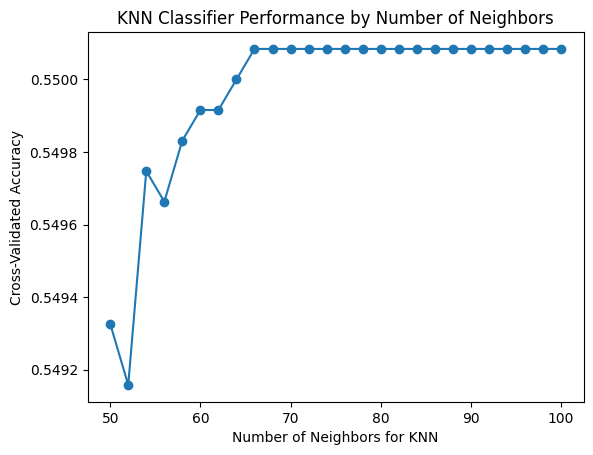

Best accuracy score: 0.5501 with n_neighbors: 66


(np.int64(66), np.float64(0.550084175084175))

In [22]:
# SUPER SMALL TEST (like 10k rows)
md = cv(X_train_tfidf_downsized, y_train_tfidf)
md

Testing n_neighbors: 50
Mean score: 0.5492
Testing n_neighbors: 52
Mean score: 0.5493
Testing n_neighbors: 54
Mean score: 0.5494
Testing n_neighbors: 56
Mean score: 0.5495
Testing n_neighbors: 58
Mean score: 0.5496
Testing n_neighbors: 60
Mean score: 0.5496
Testing n_neighbors: 62
Mean score: 0.5497
Testing n_neighbors: 64
Mean score: 0.5498
Testing n_neighbors: 66
Mean score: 0.5498
Testing n_neighbors: 68
Mean score: 0.5499
Testing n_neighbors: 70
Mean score: 0.5499
Testing n_neighbors: 72
Mean score: 0.5500
Testing n_neighbors: 74
Mean score: 0.5500
Testing n_neighbors: 76
Mean score: 0.5499
Testing n_neighbors: 78
Mean score: 0.5499
Testing n_neighbors: 80
Mean score: 0.5499
Testing n_neighbors: 82
Mean score: 0.5498
Testing n_neighbors: 84
Mean score: 0.5499
Testing n_neighbors: 86
Mean score: 0.5499
Testing n_neighbors: 88
Mean score: 0.5499
Testing n_neighbors: 90
Mean score: 0.5499
Testing n_neighbors: 92
Mean score: 0.5500
Testing n_neighbors: 94
Mean score: 0.5500
Testing n_n

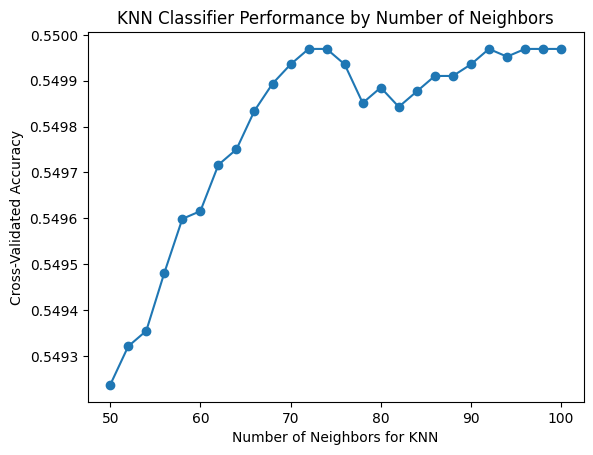

Best accuracy score: 0.5500 with n_neighbors: 72


(np.int64(72), np.float64(0.5499692854798461))

In [36]:
md = cv(X_train_tfidf_svd, y_train_tfidf)
md

In [19]:
X_train_tfidf_svd

,SVD_1,SVD_2,SVD_3,SVD_4,SVD_5,SVD_6,SVD_7,SVD_8,SVD_9,SVD_10,...,SVD_496,SVD_497,SVD_498,SVD_499,SVD_500,Helpful,Unhelpful,SummarySentiment,CleanedTextSentiment,UserAndProduct
0,0.211409,-0.112633,-0.090526,-0.051251,0.156629,0.011992,0.011334,-0.029710,-0.043538,0.035935,...,0.025086,-0.010525,0.024100,0.032481,0.004525,-0.333333,0.0,-1.223815,-4.334400,-0.562897
1,0.223712,0.183340,-0.017372,0.003127,-0.102013,0.094960,0.123757,0.081925,-0.056831,0.034002,...,-0.019391,0.001626,0.018973,0.034540,-0.028148,-0.333333,0.0,-1.649065,-4.347441,-1.772041
2,0.233048,-0.042692,0.006486,-0.020101,-0.068753,-0.018537,-0.036192,-0.018070,0.053127,-0.038649,...,0.012679,-0.025018,0.016710,0.079102,0.021065,-0.333333,17.0,-0.223815,-0.498524,-1.690089
3,0.194330,-0.075995,-0.039064,-0.041415,0.017049,-0.032864,0.047347,-0.013141,0.022534,0.040042,...,-0.015096,0.023007,0.011615,-0.019842,-0.012107,0.333333,0.0,1.222417,0.060778,-0.054947
4,0.164560,-0.048288,0.017197,-0.023012,0.004337,-0.032888,0.027271,0.036193,0.071371,0.003270,...,0.019929,0.026155,0.002882,0.002064,-0.006673,-0.333333,0.0,0.253891,-2.426427,-1.045008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1188263,0.153365,-0.001418,-0.009236,-0.009448,-0.019537,0.007130,-0.034416,-0.020789,-0.005736,-0.008314,...,0.073712,-0.010354,0.019677,0.071272,0.001860,-0.333333,0.0,0.929708,0.030266,-0.409923
1188264,0.178632,-0.034665,-0.004249,-0.018626,-0.030548,0.035867,0.049166,0.038742,0.043065,-0.036441,...,-0.041076,0.019370,-0.014461,-0.033342,-0.000733,3.333333,1.0,0.546249,0.209400,-0.964677
1188265,0.102013,0.011012,0.041723,0.003291,0.029147,-0.045862,-0.130036,0.139196,-0.008005,0.006686,...,-0.004372,0.004045,-0.010051,-0.036309,0.011004,-0.333333,0.0,0.212974,-0.086860,0.661178
1188266,0.162000,-0.055315,0.042391,-0.008200,-0.001567,0.045983,0.019535,0.008098,0.051139,-0.071053,...,-0.049517,0.044472,0.035854,-0.008854,-0.028434,0.666667,0.0,1.237979,0.278543,0.861075


In [26]:
knn = KNeighborsClassifier(n_neighbors=72)
knn.fit(X_train_tfidf_svd, y_train_full)

y_pred = knn.predict(X_test_tfidf_svd)

/opt/homebrew/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


: 

In [25]:
evaluate(y_pred)

[[ 18227      0      0      1     10]
 [ 17933      0      0      0      3]
 [ 35206      0      0      3      7]
 [ 67012      0      1     13     19]
 [158427      0      1     51    153]]
Accuracy: 6.19%
prediction set: Counter({np.float64(1.0): 296805, np.float64(5.0): 192, np.float64(4.0): 68, np.float64(3.0): 2})
